# Modify Battery Storage Parameters Example
---
In this example, we will show how to modify the battery storage parameters in the hybrid plant simulation. The major change is from using the default dispatch which is a profit maximization objective function to a load following objective function. The load follow objective will minimize system operating costs while load following.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [179]:
import numpy as np

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

import pandas as pd
import seaborn as sns

In [180]:
sns.set_theme()

### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [181]:
ev_load = pd.read_csv("../data/boulder_demand_evi.csv", header=None)

In [182]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=ev_load.iloc[:, 0].values / 1000, # MW
        solar=True,
        wind=True,
        wave=False
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [183]:
hopp_config = load_yaml("../inputs/ev-load-following-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site

hopp_config["technologies"]["pv"]["system_capacity_kw"] = 506.14620324
hopp_config["technologies"]["battery"]["system_capacity_kw"] = 375.36999625
hopp_config["technologies"]["battery"]["system_capacity_kwh"] = 3378.32993247

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [184]:
hi = HoppInterface(hopp_config)

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 20 years).

In [185]:
hi.simulate()

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [186]:
hybrid_plant = hi.system

# print("Output after losses over gross output:",
      # hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

print("Total Revenues:")
print(revs)

Annual Energies:
{"pv": 1055797.1874585426, "wind": 3274588.6247486067, "battery": -8600.594195824086, "hybrid": 3324735.153262775}
Net Present Values:
{"pv": -31974.675403165806, "wind": 55567.197293025674, "battery": -679954.6113662584, "hybrid": -1066566.3827319616}
Total Revenues:
{"pv": [0.0, 40915.91179633666, 41325.07091430002, 41738.32162344302, 42155.70483967746, 42577.26188807423, 43003.03450695498, 43433.06485202452, 43867.395500544764, 44306.06945555022, 44749.13015010572, 45196.62145160678, 45648.58766612285, 46105.07354278407, 46566.124278211915, 47031.78552099404, 47502.10337620397, 47977.124409966025, 48456.89565406567, 48941.46461060634, 49430.8792567124, 49925.18804927952, 50424.43992977232, 50928.68432907004, 51437.97117236075, 51952.35088408435], "wind": [0.0, 128783.13822938908, 130070.96961168296, 131371.6793077998, 132685.3961008778, 134012.25006188656, 135352.37256250545, 136705.8962881305, 138072.9552510118, 139453.68480352193, 140848.22165155713, 142256.703868

### Visualize Simulation Results (Optional)
Optionally, you can visualize the simulation results using plots. Several functions are provided for plotting battery output, generation profiles, and dispatch errors.

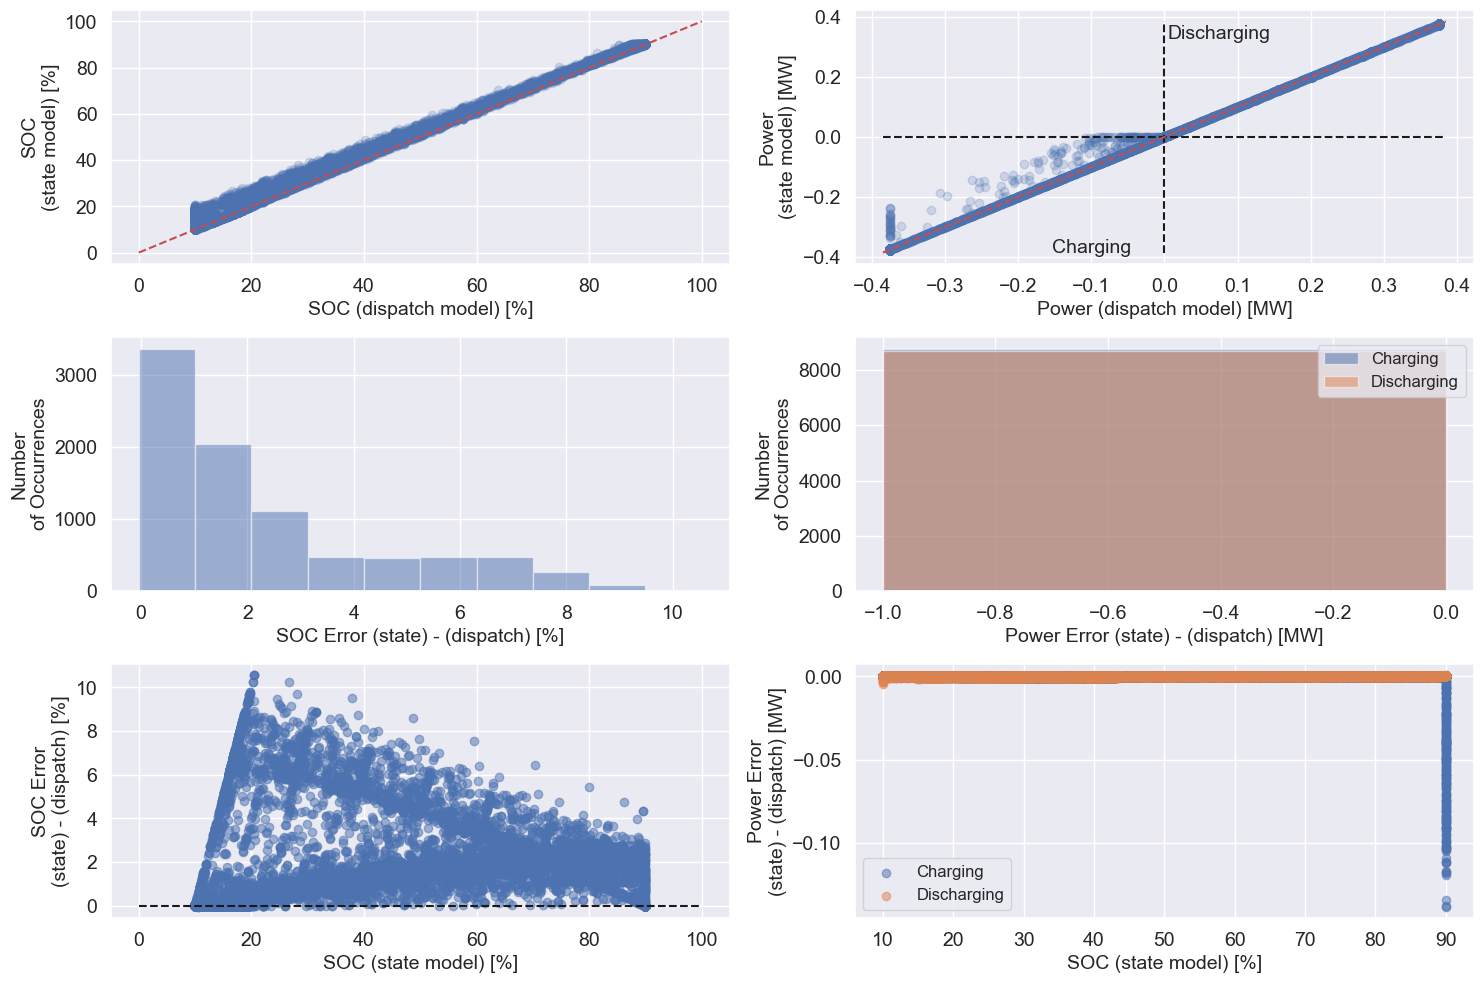

In [187]:
plot_battery_dispatch_error(hybrid_plant)

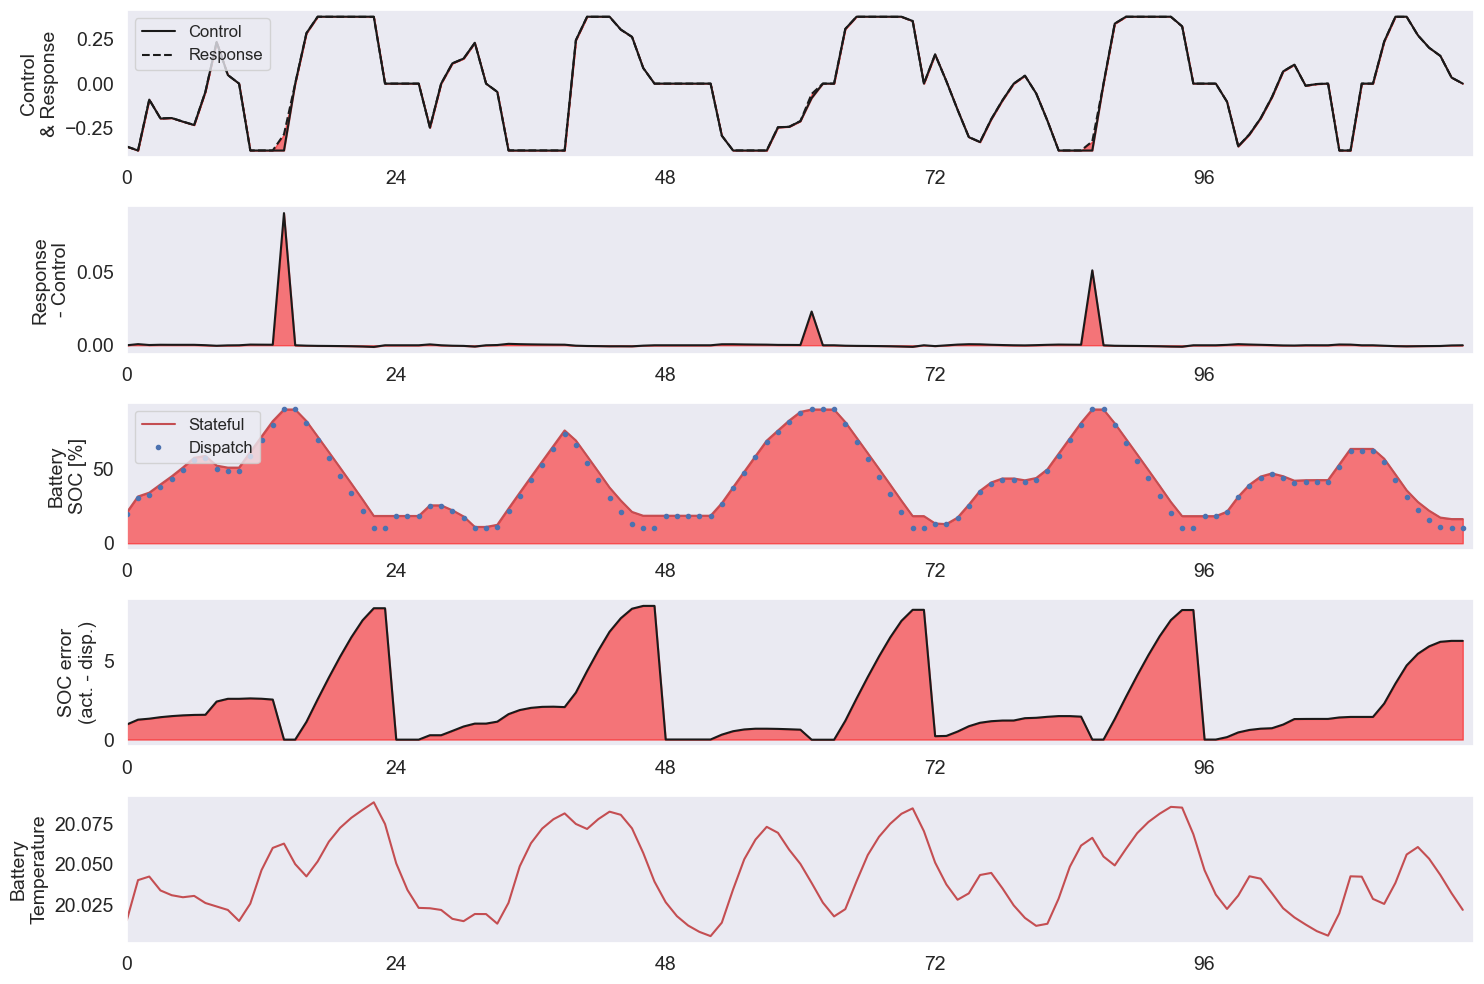

In [188]:
plot_battery_output(hybrid_plant)

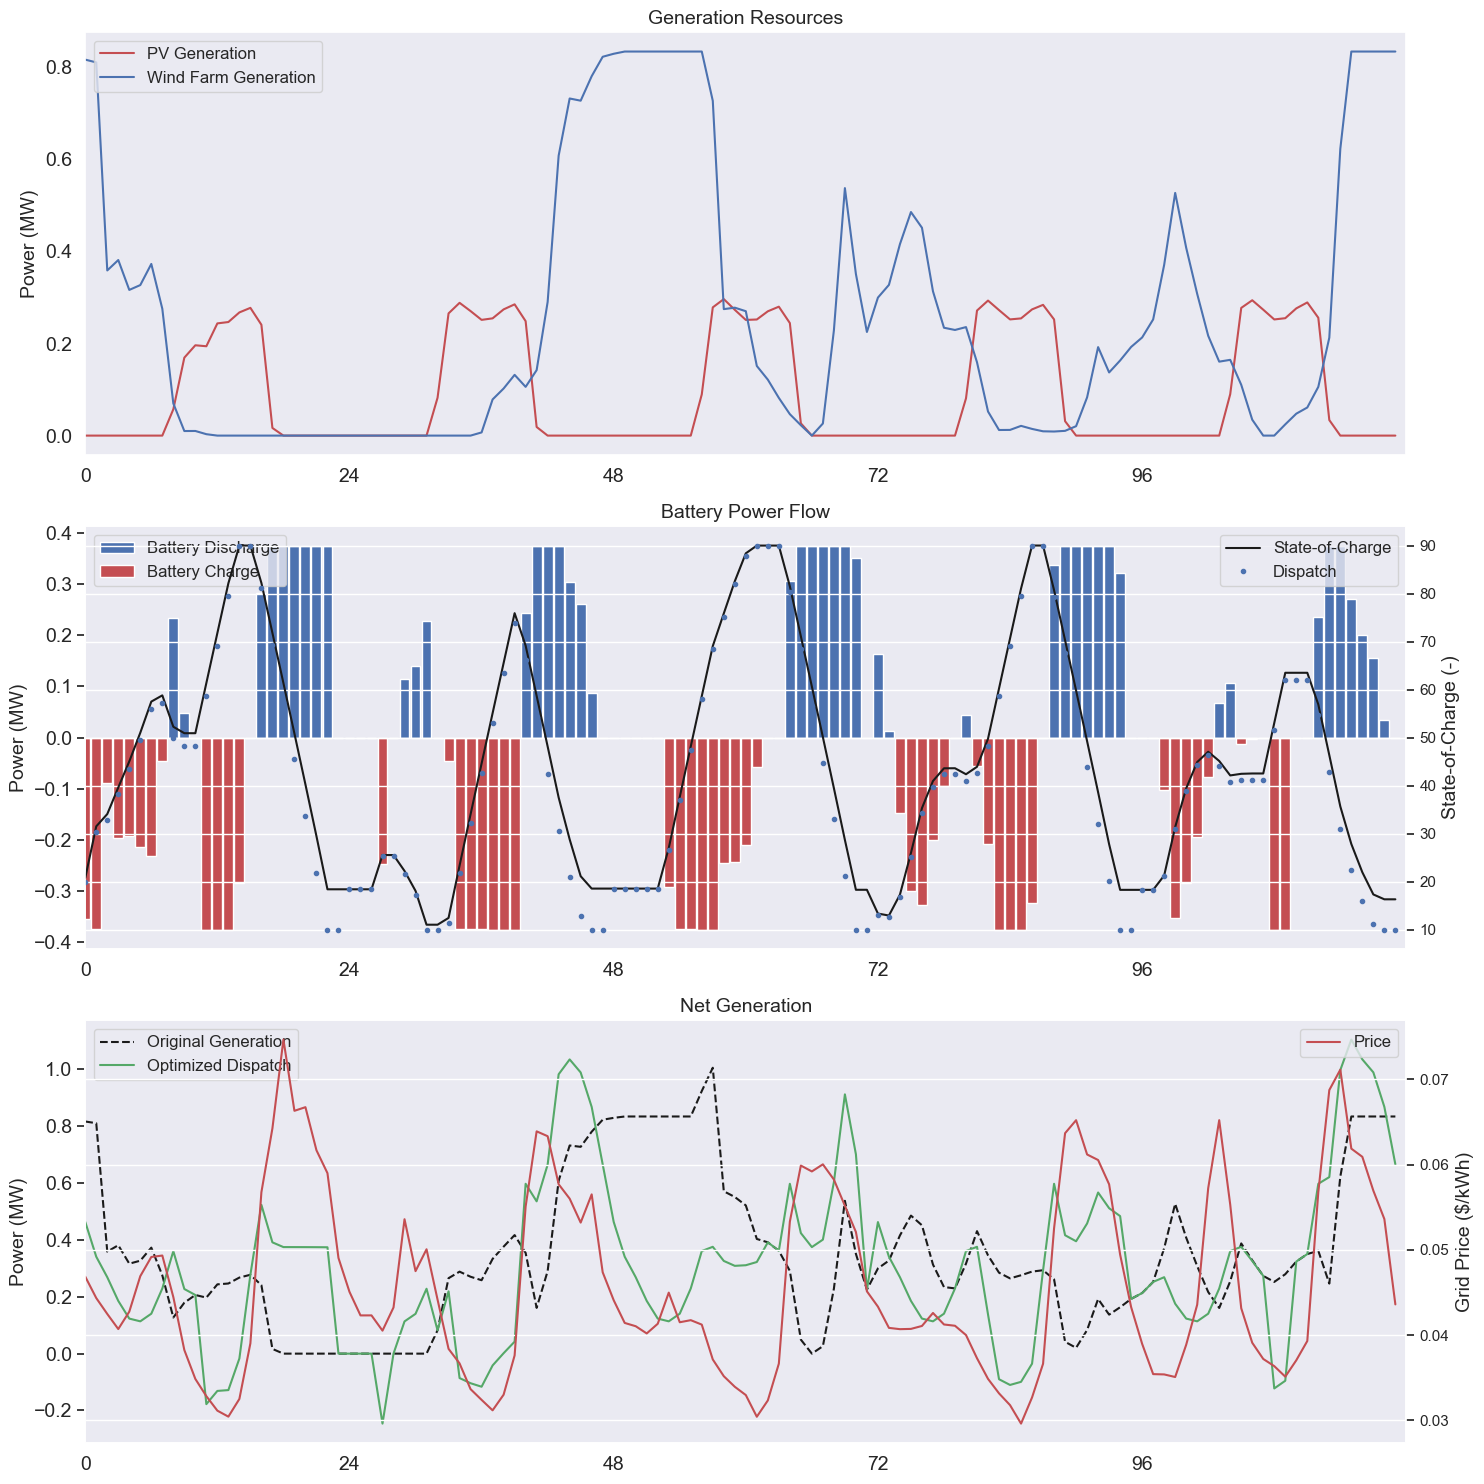

In [189]:
plot_generation_profile(hybrid_plant)

In [190]:
periods = 24*7
dates = pd.date_range(start="2022-01-01", periods=periods, freq="H")

In [191]:
hybrid_plant.grid.missed_load_percentage

0.2099887359908562

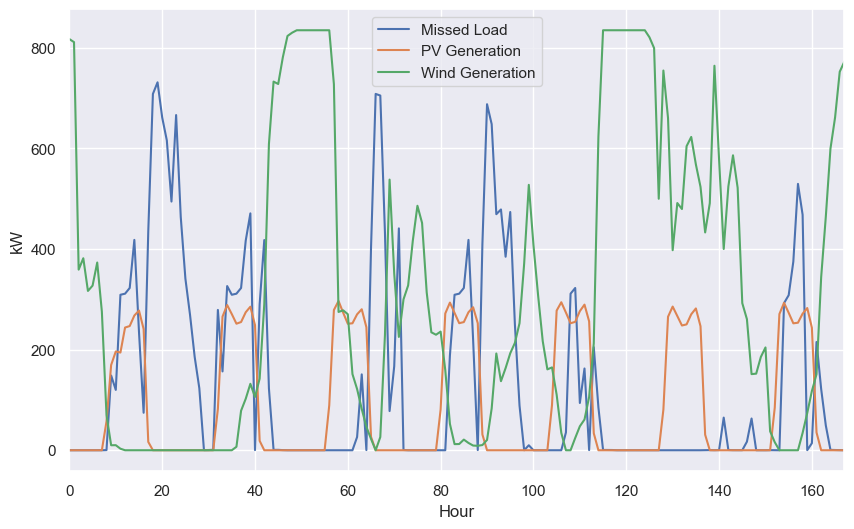

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(24*7), hybrid_plant.grid.missed_load[:24*7], label="Missed Load")
ax.plot(np.arange(24*7), hybrid_plant.pv.generation_profile[:24*7], label="PV Generation")
ax.plot(np.arange(24*7), hybrid_plant.wind.generation_profile[:24*7], label="Wind Generation")

ax.set_xmargin(0)
ax.set_xlabel("Hour")
ax.set_ylabel("kW")
ax.legend()

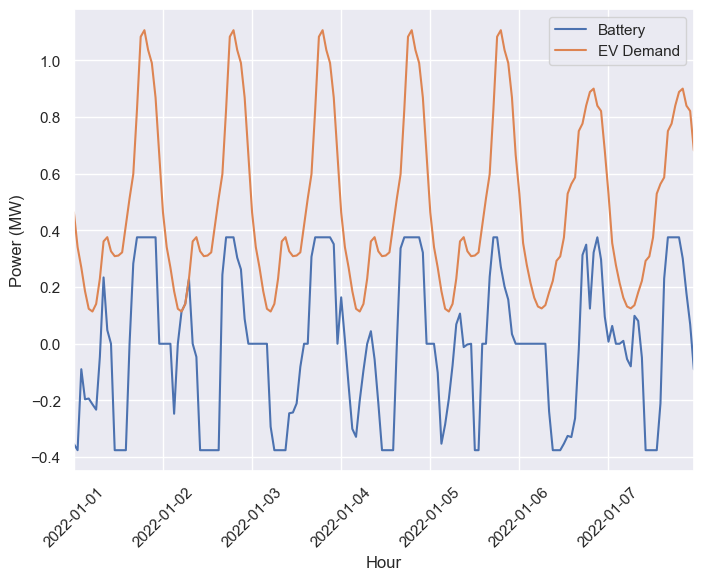

In [193]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(8760)
y = hybrid_plant.battery.outputs.dispatch_P

# ax.plot(dates, hybrid_plant.grid.missed_load[:periods], label="Missed Load")
# ax.plot(dates, hybrid_plant.pv.generation_profile[:periods], label="PV Generation")
# ax.plot(dates, hybrid_plant.wind.generation_profile[:periods], label="Wind Generation")
ax.plot(dates, y[:periods], label="Battery")
ax.plot(dates, ev_load[:periods] / 1000, label="EV Demand")

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
        
ax.set_xlabel("Hour")
ax.set_ylabel("Power (MW)")
ax.set_xmargin(0)

ax.legend()